(sec-extend)=
# Advanced: Extending lambeq

In this tutorial you will find examples of how to extend `lambeq` to add more {term}`readers <reader>`, {term}`rewrite rules <rewrite rule>` and {term}`ansätze <ansatz (plural: ansätze)>`, so you can start making your own [contributions](https://github.com/CQCL/lambeq/pulls) to the toolkit.

{download}`⬇️ Download code <../_code/extend-lambeq.ipynb>`

## Creating readers

The {py:class}`.Reader` class is an abstract base class for converting sentences to diagrams. Each {term}`reader` can be seen as a different {term}`compositional model`, and `lambeq` can accommodate any compositional model that represents sentences in a {term}`string diagram`/{term}`tensor network` form.

A concrete subclass of {py:class}`.Reader` should implement the {py:meth}`.Reader.sentence2diagram` method, which converts a single sentence into a rigid diagram.

### Reader example: "Comb" reader

In this example we will create a reader that, given a sentence, it generates the following tensor network:

<center>
<img src="../_static/images/linear.png" alt="drawing" width="320" style="margin: 20px 2px 2px 2px;"/>
</center>

Note that the particular compositional model is not appropriate for classical experiments, since the tensor that implements the layer can become very large for long sentences. However, the model can be implemented without problems on a quantum computer.

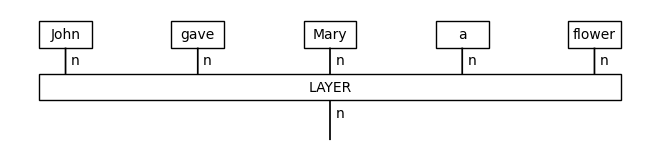

In [1]:
import warnings
warnings.filterwarnings('ignore')

from lambeq import AtomicType, Reader
from lambeq.backend.grammar import Box, Id, Word


N = AtomicType.NOUN

class CombReader(Reader):
    def sentence2diagram(self, sentence):
        words = Id().tensor(*[Word(w, N) for w in sentence.split()])
        layer = Box('LAYER', words.cod, N)
        return words >> layer

diagram = CombReader().sentence2diagram('John gave Mary a flower')
diagram.draw()

Note that, in the above code, the method {py:meth}`~lambeq.backend.grammar.Diagram.tensor` refers to the monoidal product and not to a physical tensor object. What the specific line does, using the monoidal identity {py:obj}`Id()` as a starting point, is to tensor one-by-one the boxes of the words in the sentence accumulatively, from left to right, into a single diagram, as in a standard fold operation.


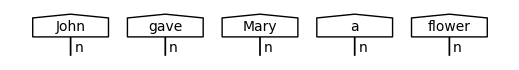

In [2]:
Id().tensor(*[Word(w, N) for w in ['John', 'gave', 'Mary', 'a', 'flower']]).draw(figsize=(5,1))

This diagram is then combined with the `layer` box to create the final output of the {term}`reader`.

```{note}
In an actual implementation, the `layer` box should be shared among all sentences so it can be trained properly.
```

## Creating rewrite rules

In [3]:
from lambeq import BobcatParser


parser = BobcatParser(verbose='text')
d = parser.sentence2diagram('The food is fresh')

### SimpleRewriteRule example: Negation functor

The {py:class}`.SimpleRewriteRule` class contains functionality that facilitates the creation of simple {term}`rewrite rules <rewrite rule>`, without the need to define a new {py:class}`.RewriteRule` class from scratch. A {py:class}`.SimpleRewriteRule` finds words with codomain `cod` and name in list `words`, then replaces their boxes with the diagram in `template`.

Here is an example of a negation {term}`functor` using {py:class}`.SimpleRewriteRule`. The functor adds a "NOT" box to the wire of certain auxiliary verbs:

In [4]:
from lambeq import AtomicType, SimpleRewriteRule


N = AtomicType.NOUN
S = AtomicType.SENTENCE
adj = N @ N.l

NOT = Box('NOT', S, S)

negation_rewrite = SimpleRewriteRule(
    cod=N.r @ S @ S.l @ N,
    template=SimpleRewriteRule.placeholder(N.r @ S @ S.l @ N) >> Id(N.r) @ NOT @ Id(S.l @ N),
    words=['is', 'was', 'has', 'have'])

```{note}
The placeholder `SimpleRewriteRule.placeholder(t)` in the template above will be replaced by a box with the same name as the original box and type `t`.
```

A list of {py:class}`.RewriteRule`s can be passed to {py:class}`.Rewriter` to create a rewriting {term}`functor`. If no list is provided, then the default rewriting rules are used (see [Diagram Rewriting](./rewrite.ipynb)).

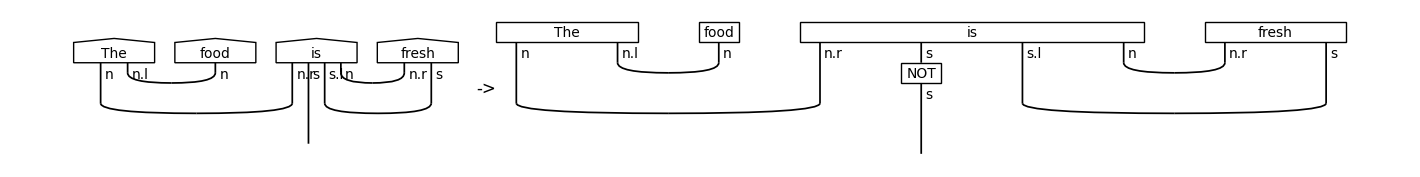

In [5]:
from lambeq import Rewriter
from lambeq.backend import draw_equation


not_d = Rewriter([negation_rewrite])(d)
draw_equation(d, not_d, symbol='->', figsize=(14, 4))

### RewriteRule example: "Past" functor

Sometimes, a {term}`rewrite rule` may become too complicated to be implemented using the {py:class}`.SimpleRewriteRule` class, so the more general {py:class}`.RewriteRule` class should be used instead. A concrete subclass of a {py:class}`.RewriteRule` should implement the methods {py:meth}`~.RewriteRule.matches` and {py:meth}`~.RewriteRule.rewrite`.

A rewriter uses the {py:meth}`~.RewriteRule.matches` methods of its {py:class}`.RewriteRule`s to detect if a rule can be applied. If there is a match, then the matching box is replaced with the result of `rewrite(box)`.

In the following example, a {term}`functor` that changes the tense of certain auxiliary verbs is implemented by directly subclassing {py:class}`.RewriteRule`:

In [6]:
from lambeq import RewriteRule


class PastRewriteRule(RewriteRule):
    mapping = {
        'is': 'was',
        'are': 'were',
        'has': 'had'
    }
    def matches(self, box):
        return box.name in self.mapping
    
    def rewrite(self, box):
        new_name = self.mapping[box.name]
        return type(box)(name=new_name, cod=box.cod)

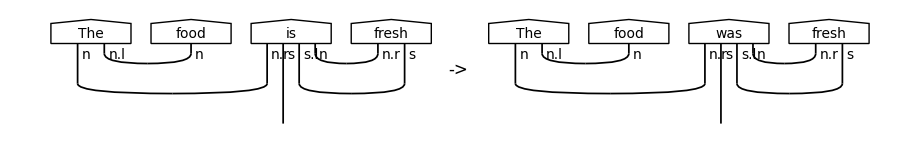

In [7]:
past_d = Rewriter([PastRewriteRule()])(d)
draw_equation(d, past_d, symbol='->', figsize=(9, 2))

## Creating ansätze

In [8]:
d = parser.sentence2diagram('We will go')

{term}`Ansätze <ansatz (plural: ansätze)>` for the quantum pipeline are implemented by extending the {py:class}`.CircuitAnsatz` class, while ansätze for the classical pipeline need to extend the {py:class}`.TensorAnsatz` class. Both classes extend {py:class}`.BaseAnsatz`, sharing a common interface. Once an {term}`ansatz <ansatz (plural: ansätze)>` is instantiated, it can be used as a {term}`functor` to convert diagrams to either a {term}`circuit <quantum circuit>` or a tensor diagram.

An {term}`ansatz <ansatz (plural: ansätze)>` should be initialised with an `ob_map` argument, a dictionary which maps a rigid type to the number of {term}`qubits <qubit>` in the quantum case, or to a dimension size (e.g. `Dim(2, 2)`) for the classical case. Some {term}`ansätze <ansatz (plural: ansätze)>` may require additional arguments (see the [API documentation](../api/lambeq.ansatz.rst) for more details).

In `lambeq`, a {term}`functor` is defined by specifying the mappings for objects `ob` and arrows `ar`. The {py:class}`.CircuitAnsatz` and {py:class}`.TensorAnsatz` classes already implement methods which extend `ob_map` to map not just base (atomic) types, but also compound types, into {term}`qubits <qubit>` and dimensions respectively. Therefore, to complete a new {term}`ansatz <ansatz (plural: ansätze)>` class, you only need to provide the mapping from rigid boxes to diagrams. This typically involves the following steps:

1. Obtain the label of the box using the `_summarise_box` method. This provides a unique token which can be used to parameterise the box.
2. Apply the {term}`functor` to the domain and the codomain of the box.
3. Construct and return an {term}`ansatz <ansatz (plural: ansätze)>` with new domain and codomain -- see how to construct diagrams using the low-level `lambeq` backend [here](./discocat.ipynb).

### CircuitAnsatz example: "Real-valued" ansatz

This {term}`ansatz <ansatz (plural: ansätze)>` always returns a tensor with real-valued entries, since the ansatz is constructed using only the CNOT and Y rotation gates, which both implement real-valued unitaries.
The {py:class}`.CircuitAnsatz` provides functionality to add postselections or discards to ensure that domains and codomains for the boxes match. To extend the {py:class}`.CircuitAnsatz` to create a new ansatz thus only involves providing a function to generate the circuit within a box.

In [9]:
from lambeq import CircuitAnsatz
from lambeq.backend.quantum import CX, Id, Ry


class RealAnsatz(CircuitAnsatz):
    def __init__(self, ob_map, n_layers, n_single_qubit_params = 1, discard = False):

        super().__init__(ob_map,
                         n_layers,
                         n_single_qubit_params,
                         discard,
                         [Ry, ])

    def params_shape(self, n_qubits):
        return (self.n_layers + 1, n_qubits)
    
    def circuit(self, n_qubits, params):
        circuit = Id(n_qubits)
        n_layers = params.shape[0] - 1

        for i in range(n_layers):
            syms = params[i]

            # adds a layer of Y rotations
            circuit >>= Id().tensor(*[Ry(sym) for sym in syms])

            # adds a ladder of CNOTs
            for j in range(n_qubits - 1):
                circuit >>= Id(j) @ CX @ Id(n_qubits - j - 2)

        # adds a final layer of Y rotations
        circuit >>= Id().tensor(*[Ry(sym) for sym in params[-1]])

        return circuit

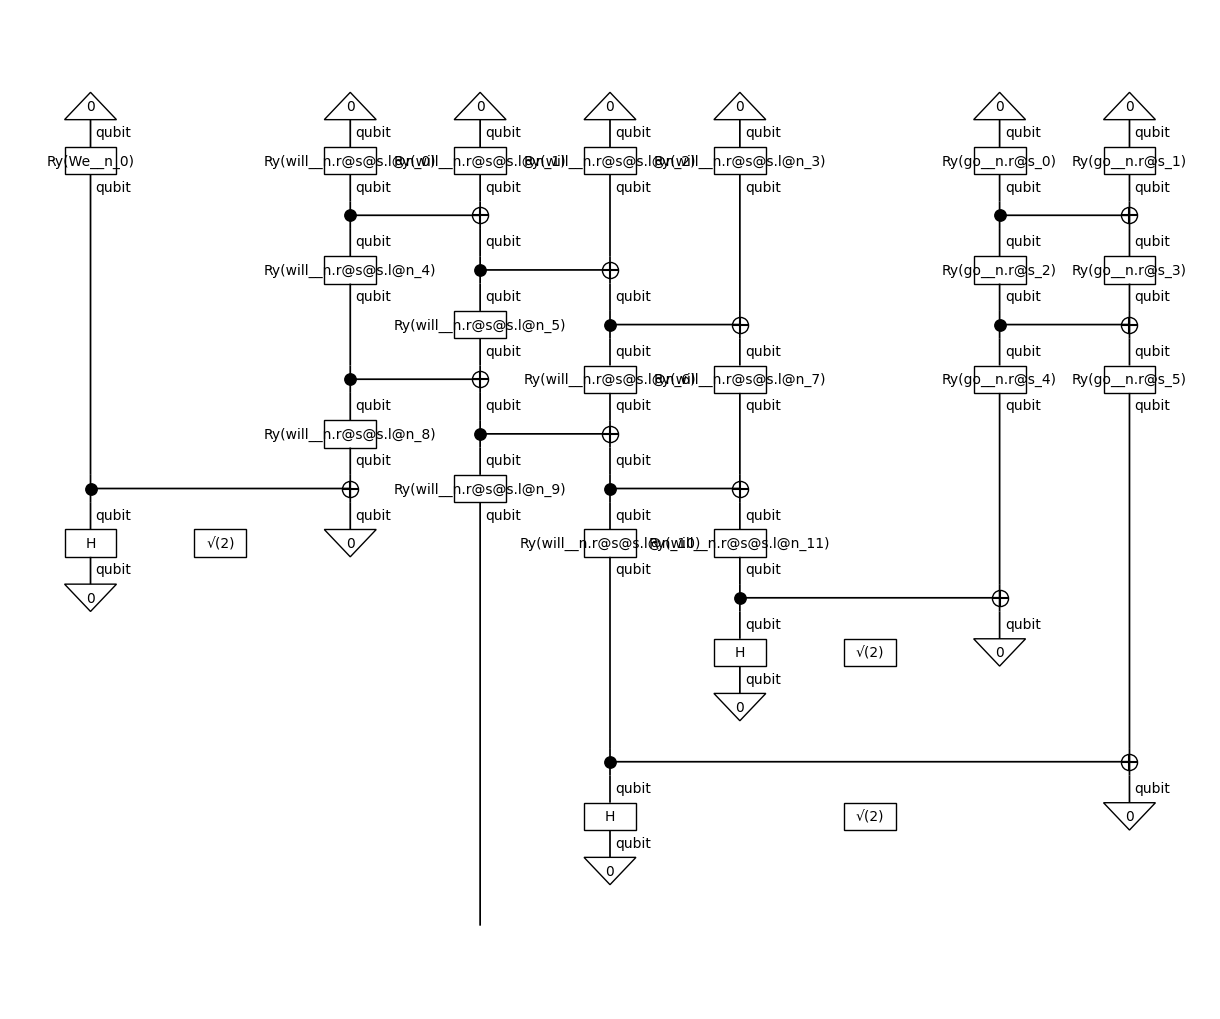

In [10]:
real_d = RealAnsatz({N: 1, S: 1}, n_layers=2)(d)
real_d.draw(figsize=(12, 10))

### TensorAnsatz example

In [11]:
from lambeq import TensorAnsatz, Symbol
from lambeq.backend import tensor
from lambeq.backend.tensor import Dim


class UnitSpiderAnsatz(TensorAnsatz):

    def _ar(self, functor, box):
        # step 1: obtain label
        name = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = functor(box.dom), functor(box.cod)

        # step 3: construct and return ansatz
        syms = Symbol(name, 2, 2)
        tnsr = tensor.Box(box.name, Dim(2), Dim(2), syms)

        return tensor.Spider(Dim(2), len(box.dom), 1) >> tnsr >> tensor.Spider(Dim(2), 1, len(box.cod))

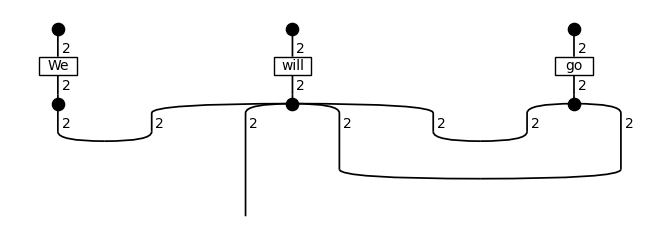

In [12]:
ansatz = UnitSpiderAnsatz({N: Dim(2), S: Dim(2)})
positive_d = ansatz(d)
positive_d.draw()

In [13]:
import numpy as np


syms = sorted(positive_d.free_symbols)
sym_dict = {k: -np.ones(k.size) for k in syms}
subbed_diagram = positive_d.lambdify(*syms)(*sym_dict.values())

subbed_diagram.eval()

array([-8., -8.])

## Contributions

We encourage you to implement your own {term}`readers <reader>`, {term}`rewrite rules <rewrite rule>` and {term}`ansätze <ansatz (plural: ansätze)>` and [contribute to lambeq](https://github.com/CQCL/lambeq/pulls) -- detailed guidelines are available [here](../CONTRIBUTING.rst). Below you can find some sources of inspiration:

- rewrites for relative pronouns: {cite:p}`sadrzadeh_2013`, {cite:p}`sadrzadeh_2014`
- rewrites to deal with coordination: {cite:p}`kartsaklis_2016a`
- rewrites to reduce the dimension size of verbs: {cite:p}`kartsaklis_2016b`
- rewrites to language circuits (DisCoCirc): {cite:p}`coecke_2021a,coecke2021b`
- ansätze benchmarked by their expressibility: {cite:p}`sim_2019`
- high-level examples of ansätze: [\[link\]](https://pennylane.ai/qml/glossary/circuit_ansatz.html)
